# Combine figure diseases LR and Cox (both with covars substracted)

Last modification: 17/01/2023

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from statsmodels.formula.api import ols, logit
from datetime import datetime
import seaborn as sns

DATE = datetime.now().strftime("%Y-%m-%d")

In [2]:

file_info_name='pheno_diseases_info.csv'
pheno_info_file = '/SSD/home/sofia/retina-phenotypes/complementary/'+str(file_info_name)
display_info=True
date_1='2023_02_22' #'2022_11_23'
date_2='2022_11_23'
ventile='covar_fix'
#output_dir ='/SSD/home/sofia/retina-phenotypes/complementary/disease_association/'

## Read Diseases
diseases_dir ='/NVME/decrypted/scratch/multitrait/UK_BIOBANK_PREPRINT/diseases_cov/'
## Read Cox
cox_file_name = str(diseases_dir) + str(date_2)+'_'+str(ventile)+'__cox_full_results.csv'
df_cox = pd.read_csv(cox_file_name, index_col=0) # columns needed  *_hr for hazard ratio, and *_pval

## Read phenos covar diseases for N cases
pheno_cov_diseases_file =diseases_dir+str(date_1)+'_covar_fix_diseases_cov.csv'

In [3]:
## Read LR
betas=pd.read_csv(diseases_dir+'reg_betas_.csv', index_col=0)
log10p=pd.read_csv(diseases_dir+'reg_log10p_.csv', index_col=0)
betas = betas.astype('float64') # in case betas was coded as object type


betas_sup=pd.read_csv(diseases_dir+'reg_betas_sup.csv', index_col=0)
log10p_sup=pd.read_csv(diseases_dir+'reg_log10p_sup.csv', index_col=0)
betas_sup = betas_sup.astype('float64') # in case betas was coded as object type

In [4]:
betas

,DBP_both,SBP_both,age_high_BP_both,PR_both,pulse_wave_arterial_stiffness_index_both,HDL_cholesterol_both,LDL_direct_both,Triglycerides_both,HbA1c_both,alcohol_intake_frequency_both,...,age_diabetes_both,age_angina_both,age_heartattack_both,age_DVT_both,age_stroke_both,age_pulmonary_embolism_both,date_reported_atherosclerosis,date_disorders_arteries_arterioles,date_AD,age_death
mean_angle_taa,-0.004780,0.000356,0.018495,-0.001552,0.005103,-0.006013,-0.000295,0.016985,0.006259,0.003470,...,0.071202,0.027551,0.054086,0.041955,0.028807,0.112175,0.147925,0.042535,0.045845,0.021356
mean_angle_tva,0.002091,0.010578,0.018279,-0.003674,0.006361,-0.000734,0.000195,0.004942,0.005004,-0.005642,...,0.030205,0.038614,0.028720,0.056861,-0.034190,0.098175,0.025951,0.037957,0.267742,0.051174
tau1_vein,0.010592,0.035423,0.094531,-0.000984,0.007832,-0.023060,-0.007323,0.010946,0.022396,0.022643,...,0.093112,0.110355,-0.011604,-0.005192,0.053284,0.037815,-0.015242,0.073923,-0.001698,0.039734
tau1_artery,-0.000157,0.013999,0.058079,-0.006425,-0.000310,0.001185,0.003395,0.014540,0.006991,-0.004848,...,0.003279,0.035915,0.004404,-0.045607,0.010695,-0.002279,0.051855,0.081511,0.133804,-0.011858
ratio_AV_DF,-0.006789,-0.008442,-0.003708,-0.005076,-0.006242,0.015285,0.006988,0.006341,-0.007211,-0.020054,...,-0.058966,-0.037074,0.014493,-0.040561,-0.022615,-0.019281,0.055656,0.037885,0.137750,-0.040794
eq_CRAE,-0.152974,-0.132251,-0.154199,-0.004521,-0.022350,-0.014420,-0.010581,-0.006918,0.011057,0.070076,...,0.055331,0.066937,0.136999,0.021792,0.072481,0.077387,0.090522,0.087047,-0.150469,0.021978
ratio_CRAE_CRVE,-0.101117,-0.073747,-0.134760,-0.044515,-0.032142,0.014535,-0.019915,-0.025417,-0.006659,0.037657,...,0.002602,0.019651,0.064433,-0.007913,0.002041,0.050954,-0.049618,0.056090,0.058239,-0.014707
D_A_std,-0.134418,-0.116736,-0.101449,0.002328,-0.014957,-0.032748,-0.007372,0.010504,0.013715,0.075328,...,0.087763,0.094972,0.138731,0.049600,0.031744,0.059372,0.184796,0.143146,0.095833,0.055279
D_V_std,-0.029769,-0.054036,0.037342,0.074184,0.025458,-0.072946,0.015646,0.061074,0.045016,0.060463,...,0.109739,0.060363,0.149468,0.066170,0.111901,0.123880,0.343574,0.151978,-0.090612,0.101378
eq_CRVE,-0.024012,-0.041240,0.013077,0.056781,0.022156,-0.040187,0.020010,0.031809,0.025595,0.030865,...,0.042920,0.050421,0.056417,0.067957,0.054484,0.038036,0.177832,0.024120,-0.156261,0.062708


In [5]:
## Only select main phenotypes:
df_cox = pd.DataFrame(df_cox, index = list(betas.index))
## Separate in pval and hazar ratio dfs:
df_cox_pvalues= df_cox.loc[:,df_cox.columns.str.endswith('_pval')]
df_cox_hazar_ratio= df_cox.loc[:,df_cox.columns.str.endswith('_hr')]
## Create column -log10(p) 
df_cox_log10p= -np.log(df_cox_pvalues)


In [6]:
### Read diseases info from csv
inf = pd.read_csv(pheno_info_file)
#inf.columns
inf_LR=inf[inf['main_supl']=='main']
# #inf_LR=inf[inf['name_LR'].notnull()]
inf_cox=inf[inf['main_supl']=='hr']


##Take list for the old and new names
list_diseases_LR = inf_LR['name_LR'].values
list_diseases_LR_new = inf_LR['final_name'].values + ' '+ inf_LR['round_N_cases_LR_cox'].values

list_diseases_cox = inf_cox['name_cox'].values
list_diseases_cox_new = 'Age ' + inf_cox['final_name'].values + ' '+ inf_cox['round_N_cases_LR_cox'].values

## To spit in Linear and logistic regressions: ## categorical is not used 
list_aux_con = ['con', 'cat']
inf_LinearR_bin = inf[inf['dtype'].isin(list_aux_con)]
#inf_LinearR_bin = inf[(inf['dtype']=='con')|(inf['dtype']=='cat')]
inf_LinearR_bin = inf_LinearR_bin[inf_LinearR_bin['main_supl']=='main']
list_diseases_LinearR = inf_LinearR_bin['name_LR'].values
list_diseases_LinearR_new = inf_LinearR_bin['final_name'].values + ' '+ inf_LinearR_bin['round_N_cases_LR_cox'].values

inf_LogisticR_bin = inf[inf['dtype']=='bin']
inf_LogisticR_bin = inf_LogisticR_bin[inf_LogisticR_bin['main_supl']=='main']

list_diseases_LogistR = inf_LogisticR_bin['name_LR'].values
list_diseases_LogistR_new = inf_LogisticR_bin['final_name'].values  + ' '+ inf_LogisticR_bin['round_N_cases_LR_cox'].values


inf_LogisticR_bin_con = inf[inf['dtype']=='bin_con']
inf_LogisticR_bin_con = inf_LogisticR_bin_con[inf_LogisticR_bin_con['main_supl']=='hr'] 

list_diseases_LogistR_both = inf_LogisticR_bin_con['name_LR'].values #+ inf_LogisticR_bin_con['name_cox'].values
list_diseases_LogistR_both_new = inf_LogisticR_bin_con['final_name'].values  + ' '+ inf_LogisticR_bin_con['round_N_cases_LR_cox'].values



In [7]:
SUPPLEMENTARY_LABELS='tau1_all,tau1_artery,tau1_vein,ratio_AV_DF,tau2_all,tau2_artery,tau2_vein,tau4_all,tau4_artery,tau4_vein,D_std,D_A_std,D_V_std,D_CVMe,D_CVMe_A,D_CVMe_V,sd_mean_size,N_median_main_arteries,N_median_main_veins,arcLength_artery,arcLength_vein,bifurcations,VD_orig_all,VD_orig_artery,VD_orig_vein,ratio_VD,FD_all,FD_artery,FD_vein,mean_angle_taa,mean_angle_tva,eq_CRAE,eq_CRVE,median_CRAE,median_CRVE,CRAE,CRVE,ratio_CRAE_CRVE,ratio_median_CRAE_CRVE,ratio_standard_CRE,medianDiameter_all,medianDiameter_artery,medianDiameter_vein,ratio_AV_medianDiameter'
SUPPLEMENTARY_NAMES='tortuosity,A tortuosity,V tortuosity,ratio tortuosity,tortuosity2,A tortuosity2,V tortuosity2,tortuosity3,A tortuosity3,V tortuosity3,std diameter,A std diameter,V std diameter,CVMe diameter,A CVMe diameter,V CVMe diameter,std norm diameter,A num main,V num main,A arc length,V arc length,bifurcations,vascular density,A vascular density,V vascular density,ratio vascular density,fractal dimension,A fractal dimension,V fractal dimension,A temporal angle,V temporal angle,A central retinal eq,V central retinal eq,A main diameter,V main diameter,A central retinal eq2,V central retinal eq2,ratio central retinal eq,ratio main diameter,ratio central retinal eq2,median diameter,A median diameter,V median diameter,ratio median diameter'

##### MAIN PHENOTYPES
MAIN_LABELS='mean_angle_taa,mean_angle_tva,tau1_vein,tau1_artery,ratio_AV_DF,eq_CRAE,ratio_CRAE_CRVE,D_A_std,D_V_std,eq_CRVE,ratio_VD,VD_orig_artery,bifurcations,VD_orig_vein,medianDiameter_artery,medianDiameter_vein,ratio_AV_medianDiameter'
MAIN_NAMES='A temporal angle,V temporal angle,V tortuosity,A tortuosity,ratio tortuosity,A central retinal eq,ratio central retinal eq,A std diameter,V std diameter,V central retinal eq,ratio vascular density,A vascular density,bifurcations,V vascular density,A median diameter,V median diameter,ratio median diameter'
type_used= 'main' #sup

if type_used=='main':
    old = MAIN_LABELS
    new = MAIN_NAMES
elif type_used=='sup':
    old = SUPPLEMENTARY_LABELS
    new = SUPPLEMENTARY_NAMES

list_old_phenotypes=list(old.split(","))
list_new_phenotypes=list(new.split(","))
    

In [8]:
##Change the name of the columns and index in beta, log10 and cox:
def filter_rename_col_index(df_, l_pehos_old, l_phenos_new, l_diseases_old, l_diseases_new, filtered_by):
    if filtered_by==True:
        df_ =df_.loc[l_pehos_old]
    else:
        df_ = df_.T
        df_ =df_.loc[l_diseases_old]
        df_ = df_.T

    df_.rename(index=dict(zip(l_pehos_old, l_phenos_new)), inplace=True)
    #print(df_)
    df_.rename(columns=dict(zip(l_diseases_old, l_diseases_new)), inplace=True)
    return df_

## linear and logistic split
log10p_logistic = filter_rename_col_index(log10p, list_old_phenotypes, list_new_phenotypes, list_diseases_LogistR, list_diseases_LogistR_new, False)
betas_logistic = filter_rename_col_index(betas, list_old_phenotypes, list_new_phenotypes, list_diseases_LogistR, list_diseases_LogistR_new, False)

log10p_linear = filter_rename_col_index(log10p, list_old_phenotypes, list_new_phenotypes, list_diseases_LinearR, list_diseases_LinearR_new, False)
betas_linear = filter_rename_col_index(betas, list_old_phenotypes, list_new_phenotypes, list_diseases_LinearR, list_diseases_LinearR_new, False)

##### All in Linear and logistic
log10p_logistic_both = filter_rename_col_index(log10p_sup, list_old_phenotypes, list_new_phenotypes, list_diseases_LogistR_both, list_diseases_LogistR_both_new, False)
betas_logistic_both = filter_rename_col_index(betas_sup, list_old_phenotypes, list_new_phenotypes, list_diseases_LogistR_both, list_diseases_LogistR_both_new, False)


## LR
log10p = filter_rename_col_index(log10p, list_old_phenotypes, list_new_phenotypes, list_diseases_LR, list_diseases_LR_new, True)
df_log10p_aux =log10p
df_log10p_aux = df_log10p_aux[list_diseases_LR_new]
log10p = df_log10p_aux

betas = filter_rename_col_index(betas, list_old_phenotypes, list_new_phenotypes, list_diseases_LR, list_diseases_LR_new, True)
df_betas_aux =betas
df_betas_aux = df_betas_aux[list_diseases_LR_new]
betas = df_betas_aux

## COX
df_cox_log10p = filter_rename_col_index(df_cox_log10p, list_old_phenotypes, list_new_phenotypes, list_diseases_cox, list_diseases_cox_new, True)
df_cox_hazar_ratio = filter_rename_col_index(df_cox_hazar_ratio, list_old_phenotypes, list_new_phenotypes, list_diseases_cox, list_diseases_cox_new, True)

print(len(df_cox_log10p), len(log10p), len(betas) )



17 17 17


In [9]:

## This colours by beta and annotates Bonferroni-significant models with an asterisk
###MLR
Bonf_thresh = -np.log10(0.05 / (log10p.shape[0] * log10p.shape[1]))
Bonf_thresh2 = -np.log10(0.001 / (log10p.shape[0] * log10p.shape[1]))

log10p_copy = log10p.copy()
log10p_copy2 = log10p.copy()
log10p_copy3 = log10p.copy()

log10p_copy= (log10p_copy>Bonf_thresh).replace({True:'*', False:''})
log10p_copy2= (log10p_copy2>Bonf_thresh2).replace({True:'*', False:''})
log10p_copy3 =log10p_copy+log10p_copy2

###COX
log10p_copy_cox = df_cox_log10p.copy()
log10p_copy2_cox = df_cox_log10p.copy()
log10p_copy3_cox = df_cox_log10p.copy()

log10p_copy_cox= (log10p_copy_cox>Bonf_thresh).replace({True:'*', False:''})
log10p_copy2_cox= (log10p_copy2_cox>Bonf_thresh2).replace({True:'*', False:''})
log10p_copy3_cox =log10p_copy_cox+log10p_copy2_cox



# Type of figure 1:

[Text(0.5, 0, 'A temporal angle'),
 Text(1.5, 0, 'V temporal angle'),
 Text(2.5, 0, 'V tortuosity'),
 Text(3.5, 0, 'A tortuosity'),
 Text(4.5, 0, 'ratio tortuosity'),
 Text(5.5, 0, 'A central retinal eq'),
 Text(6.5, 0, 'ratio central retinal eq'),
 Text(7.5, 0, 'A std diameter'),
 Text(8.5, 0, 'V std diameter'),
 Text(9.5, 0, 'V central retinal eq'),
 Text(10.5, 0, 'ratio vascular density'),
 Text(11.5, 0, 'A vascular density'),
 Text(12.5, 0, 'bifurcations'),
 Text(13.5, 0, 'V vascular density'),
 Text(14.5, 0, 'A median diameter'),
 Text(15.5, 0, 'V median diameter'),
 Text(16.5, 0, 'ratio median diameter')]

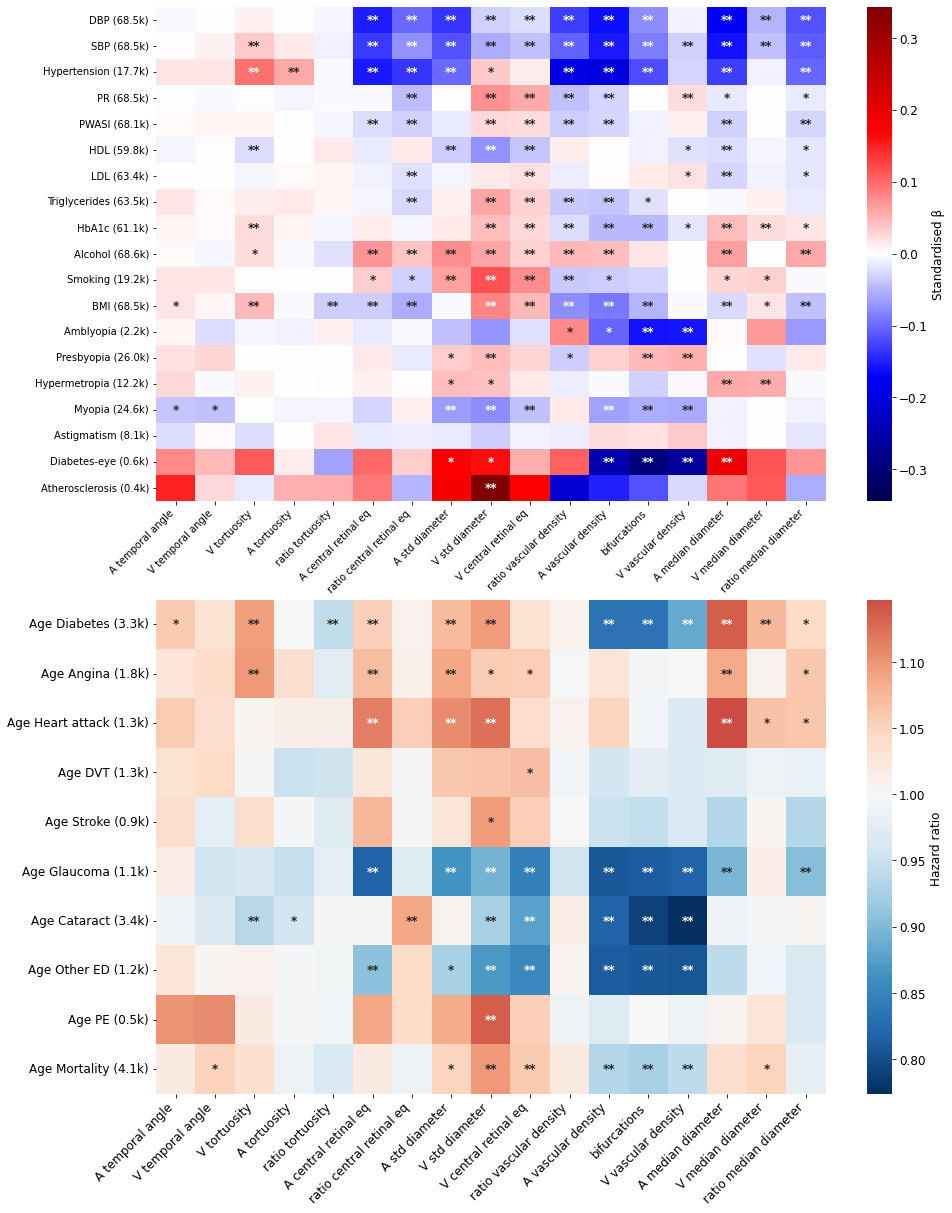

In [10]:
#img1 = mpimg.imread('2022-10-19_MLR_ventile5.jpg')
#img2 = mpimg.imread('2022-10-19_MLR_ventile5.jpg')
# plotting a line plot after changing it's width and height
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(20)

### TO DO: change: the space

ax1 = plt.subplot(211)

#gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
plt.rcParams['figure.constrained_layout.use'] = True
#ax1.yaxis.set_ticks_position('right')
plt.rcParams['font.size'] = '12'
fig1 = sns.heatmap(betas.T, 
            annot=log10p_copy3.T, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            cbar=True, #If not False
            fmt="", annot_kws={'weight': 'bold'}, 
            vmin=-abs(betas).max().max(), 
            vmax=abs(betas).max().max(), 
            cmap='seismic',alpha=1.0, cbar_kws={'label': 'Standardised \u03B2'},
               ax=ax1)
fig1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, ha='right')


ax2 = plt.subplot(212, sharex=ax1)
########### TO DO: change this figure by COX FIGURE
#ax2.yaxis.set_ticks_position('right')
fig2 = sns.heatmap(df_cox_hazar_ratio.T, 
            annot=log10p_copy3_cox.T, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            cbar=True, #False
            fmt="", annot_kws={'weight': 'bold'}, 
            vmin=(df_cox_hazar_ratio).min().min(), 
            vmax=(df_cox_hazar_ratio).max().max(), 
            center=1.0,
            cmap='RdBu_r', alpha=1.0, cbar_kws={'label': 'Hazard ratio '},
               ax=ax2)
fig2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, ha='right')

# Type of figure 2:

[Text(0.5, 0, 'Age Diabetes (3.3k)'),
 Text(1.5, 0, 'Age Angina (1.8k)'),
 Text(2.5, 0, 'Age Heart attack (1.3k)'),
 Text(3.5, 0, 'Age DVT (1.3k)'),
 Text(4.5, 0, 'Age Stroke (0.9k)'),
 Text(5.5, 0, 'Age Glaucoma (1.1k)'),
 Text(6.5, 0, 'Age Cataract (3.4k)'),
 Text(7.5, 0, 'Age Other ED (1.2k)'),
 Text(8.5, 0, 'Age PE (0.5k)'),
 Text(9.5, 0, 'Age Mortality (4.1k)')]

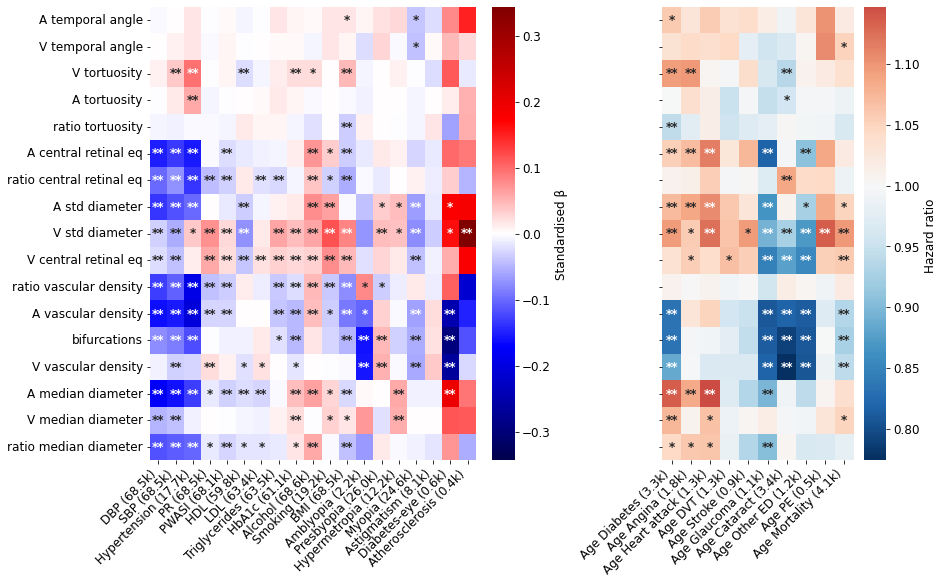

In [11]:
figsize_val=(13, 8)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=figsize_val, gridspec_kw={'width_ratios': [1.7, 1]})
#gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
plt.rcParams['figure.constrained_layout.use'] = True
#ax1.yaxis.set_ticks_position('right')
plt.rcParams['font.size'] = '12'
fig1 = sns.heatmap(betas, 
            annot=log10p_copy3, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            cbar=True, #If not False
            fmt="", annot_kws={'weight': 'bold'}, 
            vmin=-abs(betas).max().max(), 
            vmax=abs(betas).max().max(), 
            cmap='seismic',alpha=1.0, cbar_kws={'label': 'Standardised \u03B2'},
               ax=ax1)
fig1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, ha='right')

########### TO DO: change this figure by COX FIGURE
#ax2.yaxis.set_ticks_position('right')
fig2 = sns.heatmap(df_cox_hazar_ratio, 
            annot=log10p_copy3_cox, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            cbar=True, #False
            fmt="", annot_kws={'weight': 'bold'}, 
            vmin=(df_cox_hazar_ratio).min().min(), 
            vmax=(df_cox_hazar_ratio).max().max(), 
            center=1.0,
            cmap='RdBu_r', alpha=1.0, cbar_kws={'label': 'Hazard ratio '},
               ax=ax2)
fig2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, ha='right')

# Type of figure 3

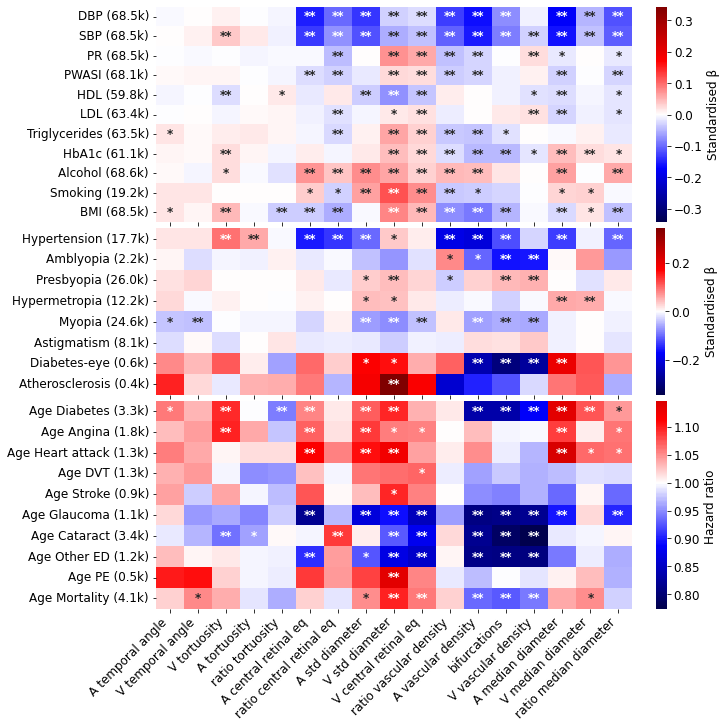

In [12]:
import matplotlib.gridspec as gridspec


def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

###LinearR
Bonf_thresh_linear = -np.log10(0.05 / (log10p_linear.shape[0] * log10p_linear.shape[1]))
Bonf_thresh2_linear = -np.log10(0.001 / (log10p_linear.shape[0] * log10p_linear.shape[1]))

linear_log10p_copy = log10p_linear.copy()
linear_log10p_copy2 = log10p_linear.copy()
linear_log10p_copy3 = log10p_linear.copy()

linear_log10p_copy= (linear_log10p_copy>Bonf_thresh_linear).replace({True:'*', False:''})
linear_log10p_copy2= (linear_log10p_copy2>Bonf_thresh2_linear).replace({True:'*', False:''})
linear_log10p_copy3 =linear_log10p_copy+linear_log10p_copy2

###LogisticR
Bonf_thresh_log = -np.log10(0.05 / (log10p_logistic.shape[0] * log10p_logistic.shape[1]))
Bonf_thresh2_log = -np.log10(0.001 / (log10p_logistic.shape[0] * log10p_logistic.shape[1]))

log_log10p_copy = log10p_logistic.copy()
log_log10p_copy2 = log10p_logistic.copy()
log_log10p_copy3 = log10p_logistic.copy()

log_log10p_copy= (log_log10p_copy>Bonf_thresh_log).replace({True:'*', False:''})
log_log10p_copy2= (log_log10p_copy2>Bonf_thresh2_log).replace({True:'*', False:''})
log_log10p_copy3 =log_log10p_copy+log_log10p_copy2



figsize_val=(10, 10)
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=figsize_val, gridspec_kw={'height_ratios': [2.9, 2.24, 2.8]})

#ax1 = plt.subplot(311)

#gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
plt.rcParams['figure.constrained_layout.use'] = True
#ax1.yaxis.set_ticks_position('right')
plt.rcParams['font.size'] = '12'
fig1 = sns.heatmap(betas_linear.T, 
            annot=linear_log10p_copy3.T, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            cbar=True, #If not False
            fmt="", annot_kws={'weight': 'bold'}, 
            vmin=-abs(betas_logistic).max().max(), ## combined
            vmax=abs(betas_logistic).max().max(), 
            #vmin=-abs(betas_linear).max().max(), ## normal
            #vmax=abs(betas_linear).max().max(), 
            cmap='seismic',alpha=1.0, cbar_kws={'label': 'Standardised \u03B2'},
               ax=ax1)
fig1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, ha='right', visible=False)
plt.ylabel('Linear regresion')

#ax2 = plt.subplot(312, sharex=ax1)
########### TO DO: change this figure by COX FIGURE
#ax2.yaxis.set_ticks_position('right')
fig2 = sns.heatmap(betas_logistic.T, 
            annot=log_log10p_copy3.T, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            cbar=True, #False
            fmt="", annot_kws={'weight': 'bold'}, 
            vmin=-abs(betas_logistic).max().max(), 
            vmax=abs(betas_logistic).max().max(), 
            cmap='seismic', alpha=1.0, cbar_kws={'label': 'Standardised \u03B2'},
               ax=ax2)
fig2.set_xticklabels(ax1.get_xticklabels(), rotation = 45, ha='right', visible=False)
plt.ylabel('Logistic regresion')

#ax3 = plt.subplot(313, sharex=ax1)
########### TO DO: change this figure by COX FIGURE
#ax2.yaxis.set_ticks_position('right')
fig3 = sns.heatmap(df_cox_hazar_ratio.T, 
            annot=log10p_copy3_cox.T, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            cbar=True, #False
            fmt="", annot_kws={'weight': 'bold'}, 
            vmin=(df_cox_hazar_ratio).min().min(), 
            vmax=(df_cox_hazar_ratio).max().max(), 
            center=1.0,
            cmap='seismic', alpha=1.0, cbar_kws={'label': 'Hazard ratio '}, ## PuOr_r , RdBu_r, BrBG_r, twilight_shifted, Spectral_r, PRGn_r
               ax=ax3)
fig3.set_xticklabels(ax3.get_xticklabels(), rotation = 45, ha='right')
#plt.xlabel('Vascular IDPs')
#plt.ylabel('Cox model')

format_axes(fig)

# Type figure 4

/SSD/home/sofia/.local/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()
/SSD/home/sofia/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


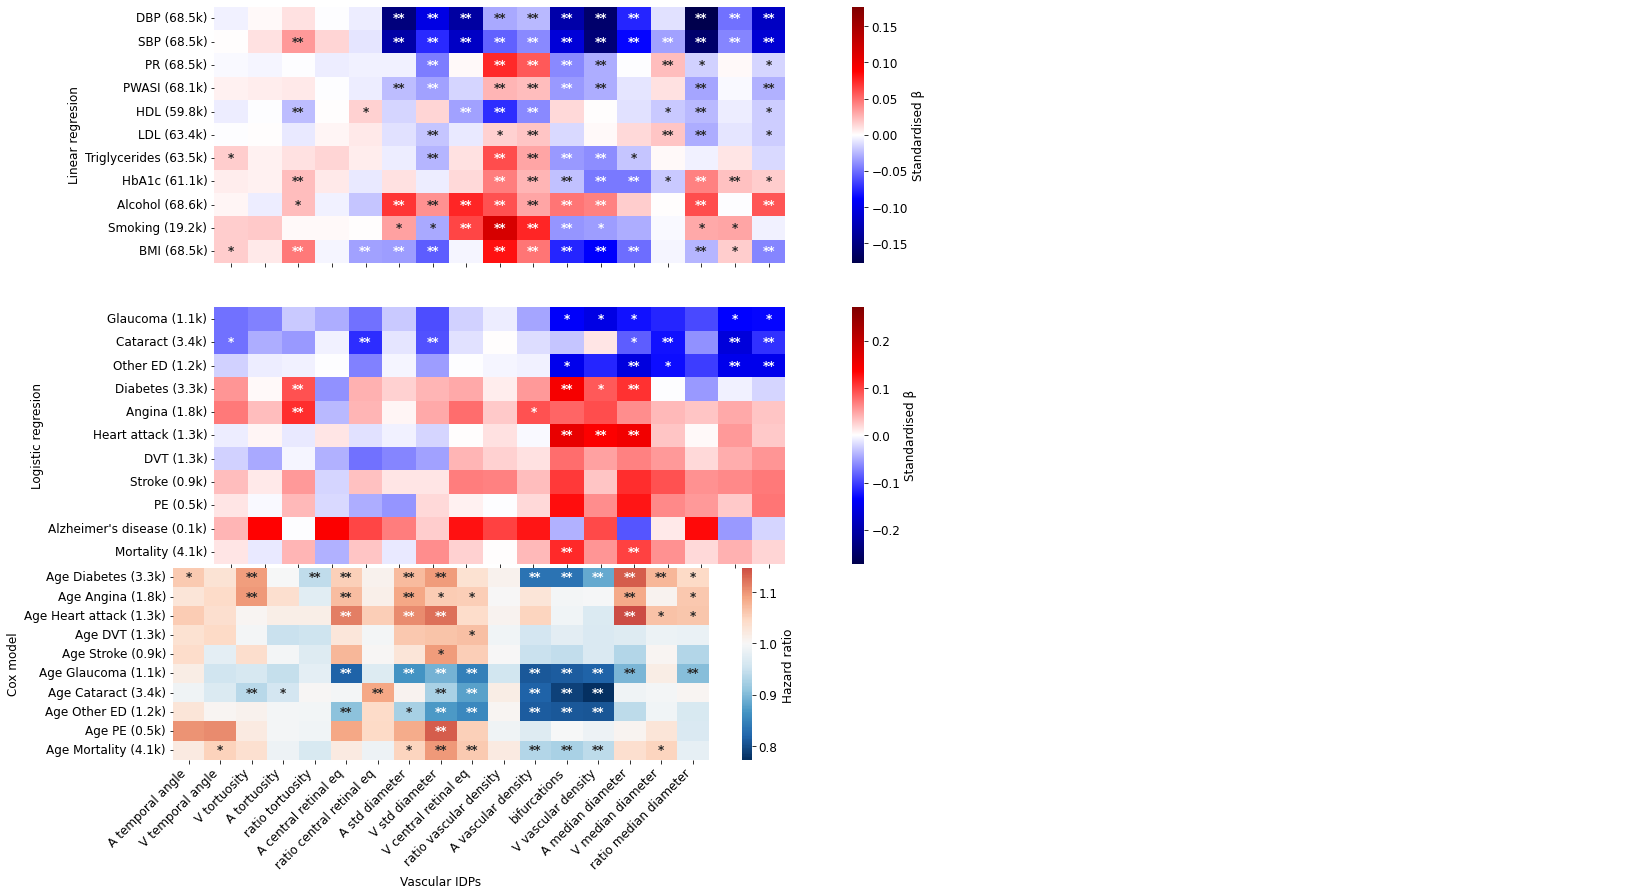

In [13]:
import matplotlib.gridspec as gridspec


def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

###LinearR
Bonf_thresh_linear = -np.log10(0.05 / (log10p_linear.shape[0] * log10p_linear.shape[1]))
Bonf_thresh2_linear = -np.log10(0.001 / (log10p_linear.shape[0] * log10p_linear.shape[1]))

linear_log10p_copy = log10p_linear.copy()
linear_log10p_copy2 = log10p_linear.copy()
linear_log10p_copy3 = log10p_linear.copy()

linear_log10p_copy= (linear_log10p_copy>Bonf_thresh_linear).replace({True:'*', False:''})
linear_log10p_copy2= (linear_log10p_copy2>Bonf_thresh2_linear).replace({True:'*', False:''})
linear_log10p_copy3 =linear_log10p_copy+linear_log10p_copy2

###LogisticR
Bonf_thresh_log_both = -np.log10(0.05 / (log10p_logistic_both.shape[0] * log10p_logistic_both.shape[1]))
Bonf_thresh2_log_both = -np.log10(0.001 / (log10p_logistic_both.shape[0] * log10p_logistic_both.shape[1]))

log_log10p_copy_both = log10p_logistic_both.copy()
log_log10p_copy2_both = log10p_logistic_both.copy()
log_log10p_copy3_both = log10p_logistic_both.copy()

log_log10p_copy_both= (log_log10p_copy_both>Bonf_thresh_log_both).replace({True:'*', False:''})
log_log10p_copy2_both= (log_log10p_copy2_both>Bonf_thresh2_log_both).replace({True:'*', False:''})
log_log10p_copy3_both =log_log10p_copy_both+log_log10p_copy2_both


f = plt.figure()
f.set_figwidth(12)
f.set_figheight(12)

### TO DO: change: the space

ax1 = plt.subplot(311)

#gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
plt.rcParams['figure.constrained_layout.use'] = True
#ax1.yaxis.set_ticks_position('right')
plt.rcParams['font.size'] = '12'
fig1 = sns.heatmap(betas_linear.T, 
            annot=linear_log10p_copy3.T, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            cbar=True, #If not False
            fmt="", annot_kws={'weight': 'bold'}, 
            vmin=-abs(betas_linear).max().max(), 
            vmax=abs(betas_linear).max().max(), 
            cmap='seismic',alpha=1.0, cbar_kws={'label': 'Standardised \u03B2'},
               ax=ax1)
fig1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, ha='right', visible=False)
plt.ylabel('Linear regresion')

ax2 = plt.subplot(312, sharex=ax1)
########### TO DO: change this figure by COX FIGURE
#ax2.yaxis.set_ticks_position('right')
fig2 = sns.heatmap(betas_logistic_both.T, 
            annot=log_log10p_copy3_both.T, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            cbar=True, #False
            fmt="", annot_kws={'weight': 'bold'}, 
            vmin=-abs(betas_logistic_both).max().max(), 
            vmax=abs(betas_logistic_both).max().max(), 
            cmap='seismic', alpha=1.0, cbar_kws={'label': 'Standardised \u03B2'},
               ax=ax2)
fig2.set_xticklabels(ax1.get_xticklabels(), rotation = 45, ha='right', visible=False)
plt.ylabel('Logistic regresion')

ax3 = plt.subplot(313, sharex=ax1)
########### TO DO: change this figure by COX FIGURE
#ax2.yaxis.set_ticks_position('right')
fig3 = sns.heatmap(df_cox_hazar_ratio.T, 
            annot=log10p_copy3_cox.T, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            cbar=True, #False
            fmt="", annot_kws={'weight': 'bold'}, 
            vmin=(df_cox_hazar_ratio).min().min(), 
            vmax=(df_cox_hazar_ratio).max().max(), 
            center=1.0,
            cmap='RdBu_r', alpha=1.0, cbar_kws={'label': 'Hazard ratio '},
               ax=ax3)
fig3.set_xticklabels(ax3.get_xticklabels(), rotation = 45, ha='right')
plt.xlabel('Vascular IDPs')
plt.ylabel('Cox model')

format_axes(fig)

# cases and controls

In [14]:
date2='2022-11-22'
N_cases_file_name = str(diseases_dir) + str(date2)+'_N_CASES_MLR_.csv' #2022-11-22_N_CASES_MLR_.csv
print(N_cases_file_name)
#df_pheno_dise =pd.read_csv(N_cases_file_name)
#df_pheno_dise

/NVME/decrypted/scratch/multitrait/UK_BIOBANK_PREPRINT/diseases_cov/2022-11-22_N_CASES_MLR_.csv


In [15]:
df_pheno_dis_cov = pd.read_csv(pheno_cov_diseases_file)

list_all_old = list(list_diseases_LR) + list(list_diseases_LogistR_both)
list_all_new = list(list_diseases_LR_new) + list(list_diseases_LogistR_both_new)

#filter
df_pheno_dis_cov_MLR = df_pheno_dis_cov[list_all_old]

#print(df_pheno_dis_cov_MLR)
def filter_rename_col(df_,list_all_old, list_all_new,):
    df_.rename(columns=dict(zip(list_all_old, list_all_new)), inplace=True)
    #print(df_)
    return df_

df_pheno_dis_cov_MLR = filter_rename_col(df_pheno_dis_cov_MLR.copy(), list_all_old, list_all_new)
#print(df_pheno_dis_cov_MLR)
#df_pheno_dis_cov_MLR=df_pheno_dis_cov[list_diseases]

list_value=[]

for col in df_pheno_dis_cov_MLR.columns:
    print(col, df_pheno_dis_cov_MLR[col].notnull().sum())
    data={
         'disease': col,
         'N': df_pheno_dis_cov_MLR[col].notnull().sum()
     }
    list_value.append(data)
df_count_val = pd.DataFrame(list_value)
    #print(col, df_pheno_dis_cov_MLR[col].value_counts())
    #if col in list_binary:
    #    print(col, df_pheno_dis_cov_MLR[col].value_counts())

#df_pheno_dis_cov_MLR['Atherosclerosis']


FileNotFoundError: [Errno 2] No such file or directory: '/NVME/decrypted/scratch/multitrait/UK_BIOBANK_PREPRINT/diseases_cov/2023_02_22_covar_fix_diseases_cov.csv'

In [ ]:
def bar_plot(df_used, title_name, set_index_column):
    #ax= df_N_cases.plot()
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5),fancybox=True, shadow=True, ncol=5)
    ax = df_used.set_index(set_index_column).plot.bar(rot=90,  figsize=figsize_val_2, fontsize=16)
    ax.get_legend().remove()
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5),fancybox=True, shadow=True, ncol=5)
    #plt.savefig(save_files+str(title_name)+'.pdf', facecolor='white', bbox_inches='tight', pad_inches=0.1, dpi=150)

figsize_val_2=(16,3)
#plt.rcParams['font.size'] = '12'
bar_plot(df_count_val, 'Number of cases', 'disease')
#df_count_val_binary=df_count_val[df_count_val['disease'].isin(list_cases_controls)]
#bar_plot(df_count_val_binary, 'Number of cases', 'disease')

NameError: name 'df_count_val' is not defined